In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import requests
import zipfile
from io import BytesIO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# Load dataset (contoh dengan dataset Air Quality Prediction)
# Download the ZIP file
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
response = requests.get(url)

In [3]:
# Unzip the content
with zipfile.ZipFile(BytesIO(response.content), 'r') as z:
    # Get the list of files in the ZIP archive
    file_list = z.namelist()

    # Look for the first CSV file
    csv_file = next((file for file in file_list if file.endswith('.csv')), None)

    if csv_file:
        # Load the CSV file
        with z.open(csv_file) as f:
            df = pd.read_csv(f, delimiter=';', decimal=',')

        print("Dataset loaded successfully.")
    else:
        print("No CSV file found in the ZIP archive.")

Dataset loaded successfully.


In [4]:
print(f"Jumlah sampel data {len(df)}")

Jumlah sampel data 9471


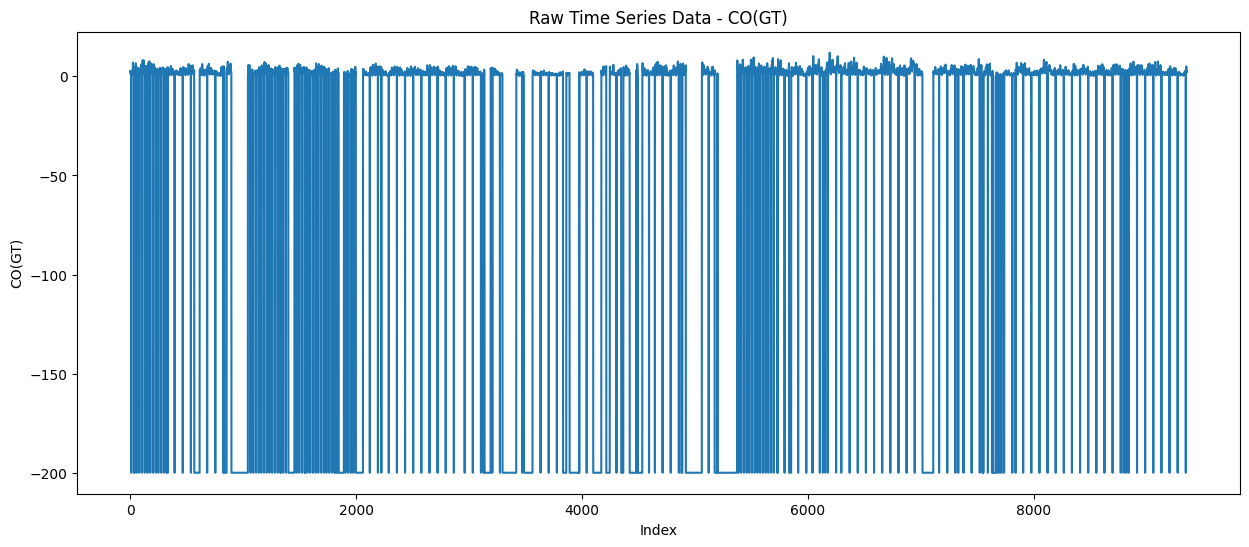

In [5]:
# Visualize the raw data
plt.figure(figsize=(15, 6))
plt.plot(df['CO(GT)'])
plt.title('Raw Time Series Data - CO(GT)')
plt.xlabel('Index')
plt.ylabel('CO(GT)')
plt.show()

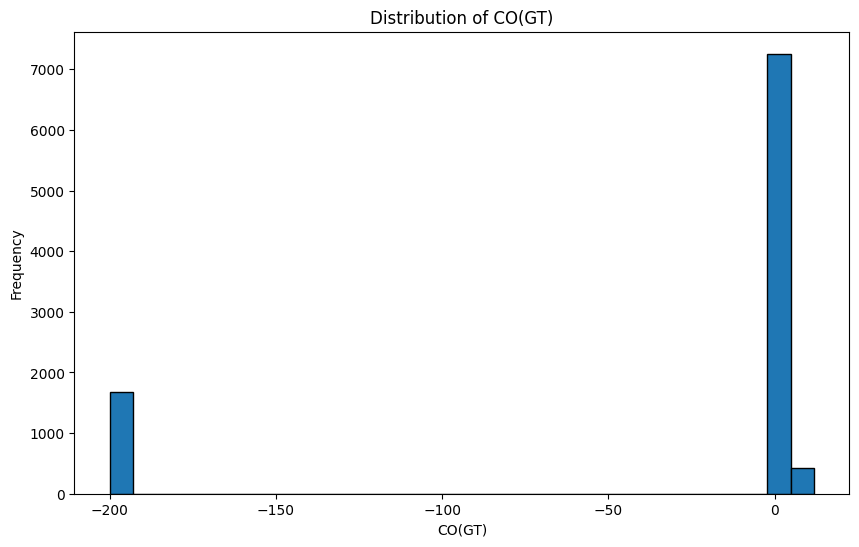

In [6]:
# Visualize the distribution of CO(GT)
plt.figure(figsize=(10, 6))
plt.hist(df['CO(GT)'], bins=30, edgecolor='black')
plt.title('Distribution of CO(GT)')
plt.xlabel('CO(GT)')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Bersihkan data (misalnya, mengganti nilai -200 menjadi NaN)
df['CO(GT)'] = df['CO(GT)'].replace(-200, np.nan)

# Gabungkan kolom Date dan Time menjadi satu kolom datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# Hapus kolom Date dan Time yang tidak diperlukan lagi
df = df.drop(['Date', 'Time'], axis=1)

# Isi nilai yang hilang dengan interpolasi linear
df['CO(GT)'] = df['CO(GT)'].interpolate()

# Set datetime sebagai indeks
df = df.set_index('Datetime')

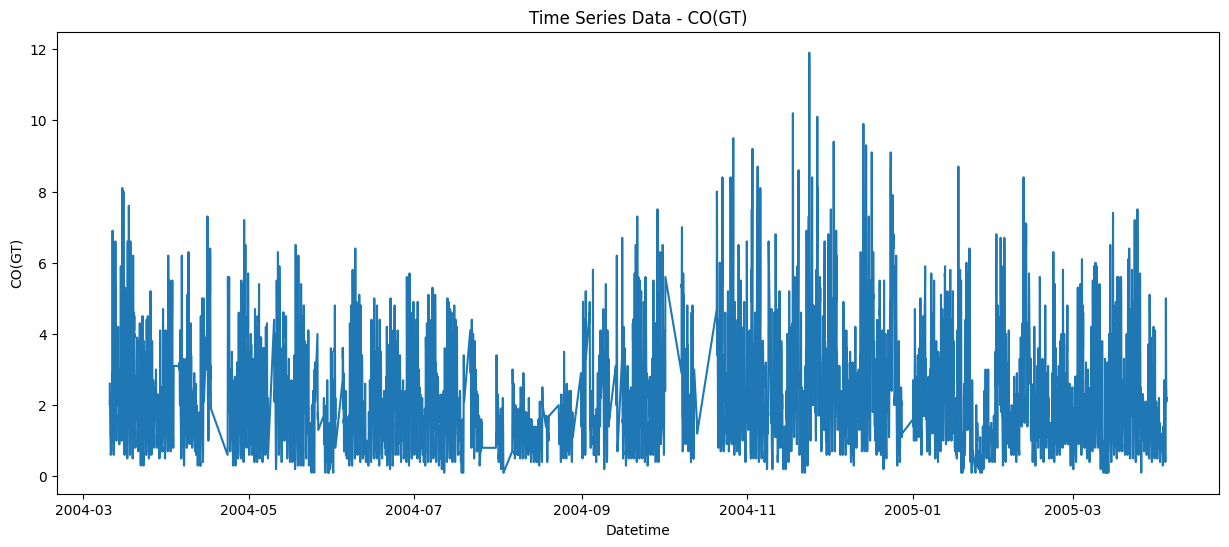

In [8]:
# Visualisasi data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['CO(GT)'])
plt.title('Time Series Data - CO(GT)')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.show()

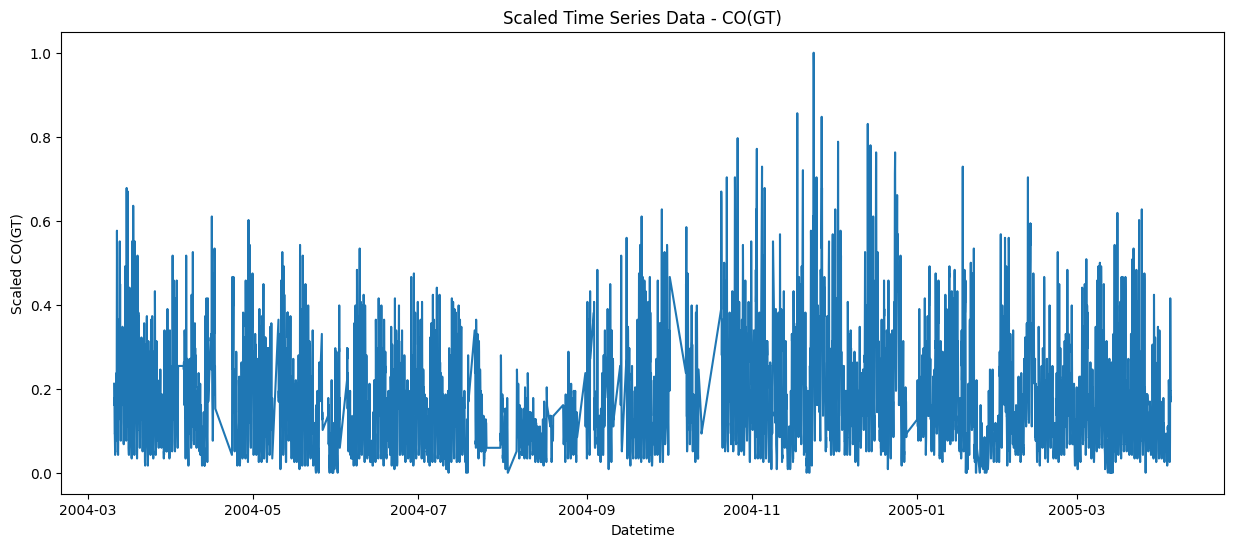

In [9]:
# Preprocessing data
scaler = MinMaxScaler()
df['CO(GT)_scaled'] = scaler.fit_transform(df[['CO(GT)']])

# Visualize the scaled data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['CO(GT)_scaled'])
plt.title('Scaled Time Series Data - CO(GT)')
plt.xlabel('Datetime')
plt.ylabel('Scaled CO(GT)')
plt.show()


In [10]:
# Membuat dataset windowed
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
# Split data menjadi train dan validation set
train_size = int(len(df) * 0.8)
train, val = df.iloc[:train_size], df.iloc[train_size:]

In [12]:
# Parameter model
window_size = 24  # Contoh window size (sesuaikan dengan kebutuhan)
batch_size = 32
shuffle_buffer_size = 1000
learning_rate = 0.001

In [13]:
# Membuat dataset windowed untuk training dan validation
train_ds = windowed_dataset(train['CO(GT)_scaled'], window_size, batch_size, shuffle_buffer_size)
val_ds = windowed_dataset(val['CO(GT)_scaled'], window_size, batch_size, shuffle_buffer_size)

In [14]:
# Membangun model sequential dengan LSTM
model = Sequential([
    LSTM(50, input_shape=(window_size, 1), return_sequences=True),
    LSTM(100),
    Dense(1)
])

In [15]:
# Compile model dengan Adam optimizer
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 70901 (276.96 KB)
Trainable params: 70901 (276.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Membuat callback
checkpoint_path = "model.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,monitor='val_loss',save_best_only=True)
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)

In [18]:
# Train the model
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/100
236/236 [==============================] - 21s 24ms/step - loss: 0.0045 - mae: 0.0691 - val_loss: 0.0032 - val_mae: 0.0567


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
236/236 [==============================] - 2s 10ms/step - loss: 0.0022 - mae: 0.0465 - val_loss: 0.0016 - val_mae: 0.0375
Epoch 3/100
236/236 [==============================] - 2s 10ms/step - loss: 0.0017 - mae: 0.0396 - val_loss: 0.0016 - val_mae: 0.0380
Epoch 4/100
236/236 [==============================] - 3s 13ms/step - loss: 0.0016 - mae: 0.0377 - val_loss: 0.0015 - val_mae: 0.0347
Epoch 5/100
236/236 [==============================] - 3s 11ms/step - loss: 0.0015 - mae: 0.0367 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 6/100
236/236 [==============================] - 3s 11ms/step - loss: 0.0014 - mae: 0.0352 - val_loss: 0.0013 - val_mae: 0.0358
Epoch 7/100
236/236 [==============================] - 2s 10ms/step - loss: 0.0014 - mae: 0.0344 - val_loss: 0.0013 - val_mae: 0.0372
Epoch 8/100
236/236 [==============================] - 2s 9ms/step - loss: 0.0013 - mae: 0.0339 - val_loss: 0.0012 - val_mae: 0.0321
Epoch 9/100
236/236 [==============================] - 4s 15ms/

59/59 [==============================] - 0s 5ms/step - loss: 0.0011 - mae: 0.0306


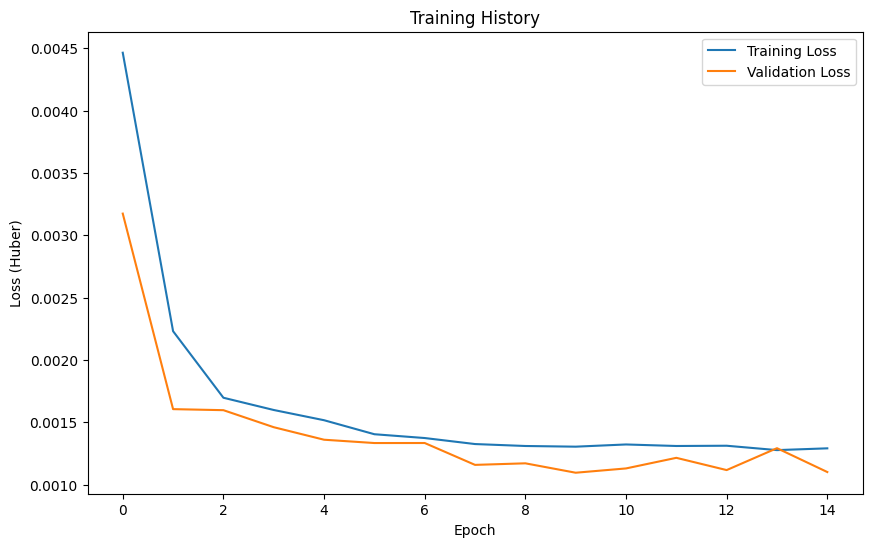

In [21]:
# Evaluate model
val_mae = model.evaluate(val_ds)

# Visualize training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.show()

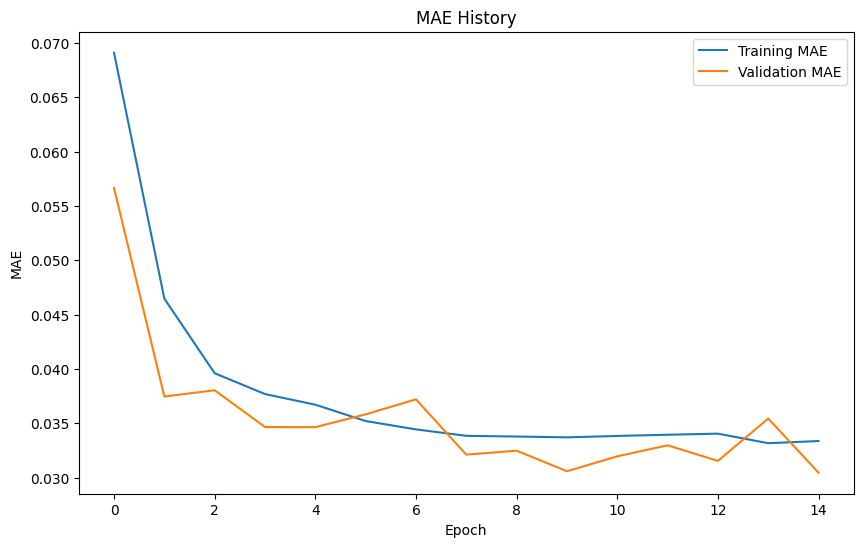

In [23]:
# Visualize training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE History')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [25]:
# Check if MAE meets the criteria
mae_threshold = 0.1 * (df['CO(GT)'].max() - df['CO(GT)'].min())
if val_mae[1] < mae_threshold:
  print("Model has met the MAE criteria.")
else:
  print("Model has not met the MAE criteria. Try tuning parameters or model architecture.")

Model has met the MAE criteria.


## Project 2 : Membuat Model Machine Learning dengan Data Time Series

Nama : Muhammad Ihsan

email : emhihsan@gmail.com